<a href="https://colab.research.google.com/github/ranitha84/gesture_recognition/blob/main/Neural_Nets_Project_Starter_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/Project_data.zip

Streaming output truncated to the last 5000 lines.
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00050.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00052.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00054.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00056.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00058.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00060.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00062.png  
   creating: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/
 extracting: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/WIN_20180926_17_35_12_Pro_00001.png  
 extracting: Project_data/t

In [1]:
import numpy as np
import os
import datetime
import os
import cv2


We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
from keras import backend as K
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D,MaxPooling2D,ZeroPadding3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers


rn.seed(30)
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
drive_path = '/content/Project_data'

train_doc = np.random.permutation(open(drive_path+'/train.csv').readlines())
val_doc = np.random.permutation(open(drive_path+'/val.csv').readlines())

train_path = drive_path+'/train'
val_path = drive_path+'/val'

batch_size = 10

image_width = 120
image_height = 120

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class AugmentedDataGenerator:

  def __init__(self,mode='train' , width=120, height=120, frames=30, channels=3, 
               crop = True, normalize = True, resize=True, augment=False):
    self.width= width
    self.height = height
    self.frames = 30
    self.channels = channels
    self.crop = crop
    self.normalize= normalize
    self.resize= resize
    self.mode = mode
    self.augment = augment
    self.datagen = ImageDataGenerator(
                    rescale= 1./255,
                    rotation_range=12,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    zoom_range=0.15,
                    horizontal_flip=True)
  
  def __crop_image(self, image):
    if image.shape[0] != image.shape[1]:
      return image[0:120,20:140]
    else:
      return image

  def __resize_image(self,image):
    return cv2.resize(image, (self.width,self.height), interpolation = cv2.INTER_AREA)

  def __normalize_image(self,image):
    #return (image - image.min())/(image.max() - image.min())
    return image/255.0

  def __augment(self, image):
    return self.datagen.random_transform(image)

  def __initialize_batch_data(self,batch_size,frames):
     batch_data = np.zeros((batch_size,frames,self.width,self.height,self.channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
     batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
     return batch_data, batch_labels

  

  def yield_batches(self, source_path, folder_list, batch_size,batch_number, t,skip=1):
    img_idx = [x for x in range(0, self.frames,skip)]
    batch_data, batch_labels = self.__initialize_batch_data(batch_size,len(img_idx))
    
    
    if self.mode == 'train' and self.augment==True:
        aug_batch_data,aug_batch_labels = self.__initialize_batch_data(batch_size,len(img_idx))
        
    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ t[folder + (batch_number*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
            image = cv2.imread(source_path+'/'+ t[folder + (batch_number*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes
            normalized_image = image
            # crop image
            if self.crop:
              normalized_image = self.__crop_image(normalized_image)
            # resize the image
            if self.normalize:
              batch_data[folder,idx] = self.__normalize_image(self.__resize_image(normalized_image))
            else:
              batch_data[folder,idx] = self.__resize_image(normalized_image)
            
            if self.mode =='train' and self.augment==True:
                aug_batch_data[folder,idx] = self.__augment(self.__resize_image(image))   
        batch_labels[folder, int(t[folder + (batch_number*batch_size)].strip().split(';')[2])] = 1
        if self.mode == 'train' and self.augment==True:
           aug_batch_labels[folder, int(t[folder + (batch_number*batch_size)].strip().split(';')[2])] = 1
         
    if self.mode == 'train' and self.augment==True:  
      batch_data = np.append(batch_data, aug_batch_data, axis = 0) 
      batch_labels = np.append(batch_labels, aug_batch_labels, axis = 0) 
    # data augmentation
    return batch_data, batch_labels

  def generator(self, source_path, folder_list, batch_size,skip=1):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(folder_list)/batch_size)
        for batch in range(num_batches): # we iterate over the number of batches
            yield self.yield_batches(source_path, folder_list, batch_size, batch, t,skip)

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
          batch_size = len(folder_list) - (batch_size*num_batches)
          yield self.yield_batches(source_path, folder_list, batch_size, num_batches, t,skip)

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
class DecayLR(tf.keras.callbacks.Callback):
    def __init__(self, base_lr=0.01, decay_epoch=1):
        super(DecayLR, self).__init__()
        self.base_lr = base_lr
        self.decay_epoch = decay_epoch 
        self.lr_history = []
        
    def on_train_begin(self, logs={}):
        K.set_value(self.model.optimizer.lr, self.base_lr)

    def on_epoch_end(self, epoch, logs={}):
        new_lr = self.base_lr * (0.5 ** (epoch // self.decay_epoch))
        self.lr_history.append(K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

In [7]:
import matplotlib.pyplot as plt # for plotting


def plot_accuracy(history):
  plt.figure(figsize=(16,6))
  plt.subplot(1,2,1)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.legend(['train', 'validation'])

  plt.subplot(1,2,2)
  plt.plot(history.history['categorical_accuracy'])
  plt.plot(history.history['val_categorical_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs')
  plt.legend(['train', 'validation'])

  plt.show() 

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [16]:
class ModelGenerator:

  def __init__(self, input_shape = (30,120,120,3),num_classes = 5):
    self.input_shape= input_shape
    self.num_classes = num_classes
    print(self.input_shape)


 
  def model_cv3D(self):
      """ Model built using Conv3D and MaxPooling3D
      """
      model = Sequential()
      model.add(Conv3D(
          8, kernel_size=(3,3,3), activation='relu', input_shape=self.input_shape
      ))
      model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
      model.add(Conv3D(16, (3,3,3), activation='relu'))
      model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
      model.add(Conv3D(32, (3,3,3), activation='relu'))
      model.add(Conv3D(32, (3,3,3), activation='relu'))
      model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
      model.add(Conv3D(64, (2,2,2), activation='relu'))
      model.add(Conv3D(64, (2,2,2), activation='relu'))
      model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))

      model.add(Flatten())
      model.add(Dense(512))
      model.add(Dropout(0.5))
      model.add(Dense(256))
      model.add(Dropout(0.5))
      model.add(Dense(self.num_classes, activation='softmax'))

      return model

  def model_cv3D2(self):
      """ Model built using Conv3D and MaxPooling3D
          Adding additional layers 
      """
      model = Sequential()
      # 1st layer group
      model.add(Conv3D(16, (3, 3, 3), activation='relu',
                        padding='same',
                        input_shape=self.input_shape))
      model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
      # 2nd layer group
      model.add(Conv3D(32, (3, 3, 3), activation='relu',
                        padding='same'))
      model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
      # 3rd layer group
      model.add(Conv3D(64, (3, 3, 3), activation='relu',
                        padding='same'))
      model.add(Conv3D(64, (3, 3, 3), activation='relu',
                        padding='same'))
      model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
      # 4th layer group
      model.add(Conv3D(128, (3, 3, 3), activation='relu',
                        padding='same'))
      model.add(Conv3D(128, (3, 3, 3), activation='relu',
                        padding='same'))
      model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))

      # 5th layer group
      model.add(Conv3D(256, (3, 3, 3), activation='relu',
                        padding='same'))
      model.add(Conv3D(256, (3, 3, 3), activation='relu',
                        padding='same'))
      model.add(ZeroPadding3D(padding=(0, 1, 1)))
      model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
      model.add(Flatten())

      # Fully connected layers group
      model.add(Dense(512, activation='relu'))
      model.add(Dropout(0.5))
      model.add(Dense(512, activation='relu'))
      model.add(Dropout(0.5))
      model.add(Dense(self.num_classes, activation='softmax'))

      return model

  def model_cnn_rnn(self):
    """CNN + RNN.
        TimeDistributed is used along with CNN 
    """
    model = Sequential()
    model.add(TimeDistributed(Conv2D(32, (7, 7), strides=(2, 2),
        activation='relu', padding='same'), input_shape=self.input_shape))
    model.add(TimeDistributed(Conv2D(32, (3,3),
        kernel_initializer="he_normal", activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

    model.add(TimeDistributed(Conv2D(64, (3,3),
        padding='same', activation='relu')))
    model.add(TimeDistributed(Conv2D(64, (3,3),
        padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

    model.add(TimeDistributed(Conv2D(128, (3,3),
        padding='same', activation='relu')))
    model.add(TimeDistributed(Conv2D(128, (3,3),
        padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

    model.add(TimeDistributed(Conv2D(256, (3,3),
        padding='same', activation='relu')))
    model.add(TimeDistributed(Conv2D(256, (3,3),
        padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
    
    model.add(TimeDistributed(Conv2D(512, (3,3),
        padding='same', activation='relu')))
    model.add(TimeDistributed(Conv2D(512, (3,3),
        padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

    model.add(TimeDistributed(Flatten()))

    model.add(Dropout(0.5))
    model.add(LSTM(256, return_sequences=False, dropout=0.5))
    model.add(Dense(self.num_classes, activation='softmax'))

    return model

  def model_cnn3D_WithBatchNormalization(self):
    model = Sequential()

    model.add(Conv3D(8, 
                    kernel_size=(3,3,3), 
                    input_shape=self.input_shape,
                    padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))

    model.add(Conv3D(16, 
                    kernel_size=(3,3,3), 
                    padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))

    model.add(Conv3D(32, 
                    kernel_size=(1,3,3), 
                    padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))

    model.add(Conv3D(64, 
                    kernel_size=(1,3,3), 
                    padding='same'))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))

    #Flatten Layers
    model.add(Flatten())

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    #softmax layer
    model.add(Dense(self.num_classes, activation='softmax'))

    return model

# Train Model

- This method takes the model, batch size and the number of epochs to train the model

- Its the takes the train and validation genarators to the train the data on the data set

In [20]:
def train_model( model, batch_size, num_epochs, train_generator, val_generator, _optimizer=None, learning_rate=0.01):
    curr_dt_time = datetime.datetime.now()
    num_train_sequences = len(train_doc)
    print('# training sequences =', num_train_sequences)
    num_val_sequences = len(val_doc)
    print('# validation sequences =', num_val_sequences)
    print ('# epochs =', num_epochs)

    print('Number of epochs {}'.format(num_epochs))
    print('Batch Size {}'.format(batch_size))
    print('Current Date time {}'.format(curr_dt_time))

    # Defining call back lists

    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}--{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, 
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 save_weights_only=False, 
                                 mode='auto')

    LR = ReduceLROnPlateau(monitor='val_loss',factor=0.2, patience=2, model='auto', verbose=1)
    #ER = EarlyStopping(monitor='val_loss',patience=10, mode='auto', verbose=1),


    callbacks_list = [checkpoint, LR]

    if _optimizer == None:
      optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif _optimizer == 'sgd':
      optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
      dr = DecayLR()
      callbacks_list.append(dr)
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print (model.summary())
   
    if (num_train_sequences%batch_size) == 0:
      steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    
    history = model.fit(train_generator, 
              steps_per_epoch=steps_per_epoch, 
              epochs=num_epochs, 
              verbose=1, 
              callbacks=callbacks_list, 
              validation_data=val_generator, 
              validation_steps=validation_steps, 
              class_weight=None, 
              initial_epoch=0,
              workers=1)
    plot_accuracy(history)
    K.clear_session()

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

## Model 1
- Have used Cov3D and Maxpooling 3D
- Training with 15 images from each video. Using optimizer as Adam
- Number of epochs used for training the model is 30 

(15, 120, 120, 3)
# training sequences = 663
# validation sequences = 100
# epochs = 50
Number of epochs 50
Batch Size 10
Current Date time 2021-02-27 13:19:04.149346
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 13, 118, 118, 8)   656       
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 13, 59, 59, 8)     0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 11, 57, 57, 16)    3472      
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 11, 28, 28, 16)    0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 9, 26, 26, 32)     13856     
_________________________________________________________________
conv3d_15 (Conv3D) 

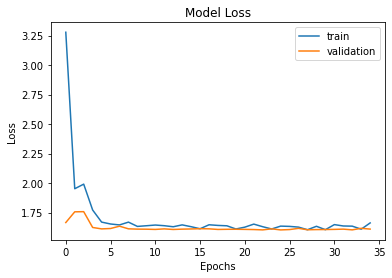

In [50]:
train_gen = AugmentedDataGenerator(mode='train')
val_gen = AugmentedDataGenerator(mode='val')
skip_image_size=2

train_generator = train_gen.generator(train_path, train_doc, 20,skip_image_size)
val_generator = val_gen.generator(val_path, val_doc, 20,skip_image_size)

model_generator = ModelGenerator(input_shape=(15,120,120,3))

model = model_generator.model_cv3D()

num_epochs =50
train_model(model=model,batch_size=batch_size,num_epochs=num_epochs,train_generator=train_generator,val_generator=val_generator)

We see that the Validation accurach in the previous model was only 25%. Lets try to augment the images and see whether we get appreciable improvement in the model

# Model 1 with image augmentation and increasing batch size

(15, 120, 120, 3)
# training sequences = 663
# validation sequences = 100
# epochs = 50
Number of epochs 50
Batch Size 30
Current Date time 2021-02-27 13:28:42.649291
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 13, 118, 118, 8)   656       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 13, 59, 59, 8)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 11, 57, 57, 16)    3472      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 11, 28, 28, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 9, 26, 26, 32)     13856     
_________________________________________________________________
conv3d_3 (Conv3D)    

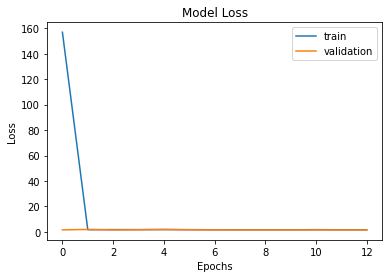

In [51]:
train_gen = AugmentedDataGenerator(mode='train',augment=True)
val_gen = AugmentedDataGenerator(mode='val',augment=True)
skip_image_size=2
batch_size = 30

train_generator = train_gen.generator(train_path, train_doc, batch_size,skip_image_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size,skip_image_size)

model_generator = ModelGenerator(input_shape=(15,120,120,3))

model = model_generator.model_cv3D()

num_epochs =50
train_model(model=model,batch_size=batch_size,num_epochs=num_epochs,train_generator=train_generator,val_generator=val_generator)

# Model 1 with SGD optimizer


(15, 120, 120, 3)
# training sequences = 663
# validation sequences = 100
# epochs = 30
Number of epochs 30
Batch Size 50
Current Date time 2021-02-27 13:35:57.819645
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 13, 118, 118, 8)   656       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 13, 59, 59, 8)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 11, 57, 57, 16)    3472      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 11, 28, 28, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 9, 26, 26, 32)     13856     
_________________________________________________________________
conv3d_3 (Conv3D)    

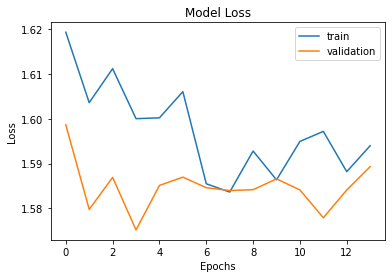

In [54]:
train_gen = AugmentedDataGenerator(mode='train')
val_gen = AugmentedDataGenerator(mode='val')
skip_image_size=2
batch_size= 50

train_generator = train_gen.generator(train_path, train_doc, batch_size,skip_image_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size,skip_image_size)

model_generator = ModelGenerator(input_shape=(15,120,120,3))

model = model_generator.model_cv3D()

num_epochs =30
train_model(model=model,batch_size=batch_size,num_epochs=num_epochs,train_generator=train_generator,val_generator=val_generator,_optimizer='sgd', learning_rate=0.05)

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

(10, 120, 120, 3)
# training sequences = 663
# validation sequences = 100
# epochs = 50
Number of epochs 50
Batch Size 50
Current Date time 2021-02-27 14:14:37.093682
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_16 (TimeDis (None, 10, 60, 60, 32)    4736      
_________________________________________________________________
time_distributed_17 (TimeDis (None, 10, 58, 58, 32)    9248      
_________________________________________________________________
time_distributed_18 (TimeDis (None, 10, 29, 29, 32)    0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 10, 29, 29, 64)    18496     
_________________________________________________________________
time_distributed_20 (TimeDis (None, 10, 29, 29, 64)    36928     
_________________________________________________________________
time_distributed_21

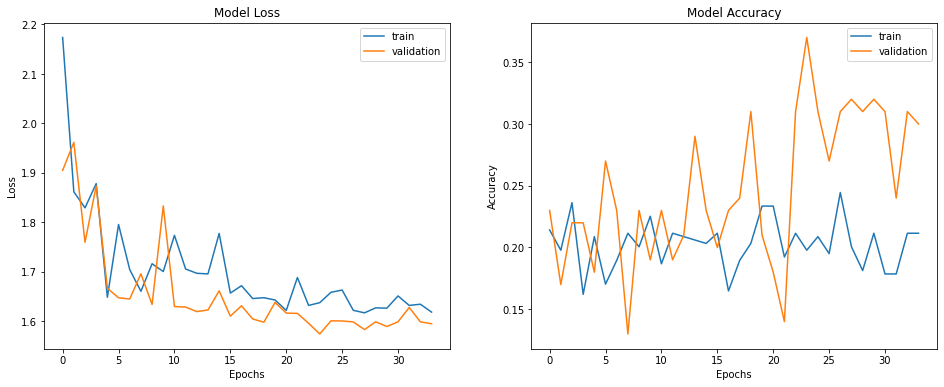

In [65]:
train_gen = AugmentedDataGenerator(mode='train',augment=True)
val_gen = AugmentedDataGenerator(mode='val',augment=True)

skip_image_size=2
batch_size= 50
num_epochs =50

train_generator = train_gen.generator(train_path, train_doc, batch_size,skip_image_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size,skip_image_size)

model_generator = ModelGenerator(input_shape=(15,120,120,3))

model = model_generator.model_cnn_rnn()

train_model(model,batch_size, num_epochs,train_generator,val_generator)

# Model 3 with  Adam optimizer and batch_size as 60

(15, 120, 120, 3)
# training sequences = 663
# validation sequences = 100
# epochs = 60
Number of epochs 60
Batch Size 60
Current Date time 2021-02-27 14:37:55.395501
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_25 (Conv3D)           (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
max_pooling3d_14 (MaxPooling (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_26 (Conv3D)           (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
max_pooling3d_15 (MaxPooling (None, 15, 30, 30, 32)    0         
_________________________________________________________________
conv3d_27 (Conv3D)           (None, 15, 30, 30, 64)    55360     
_________________________________________________________________
conv3d_28 (Conv3D) 

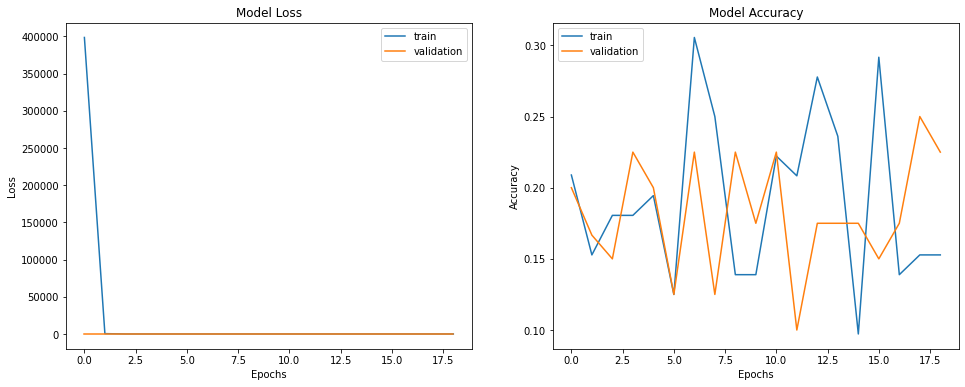

In [81]:
train_gen = AugmentedDataGenerator(mode='train',augment=True)
val_gen = AugmentedDataGenerator(mode='val',augment=True)

skip_image_size=2
batch_size= 60
num_epochs =60

train_generator = train_gen.generator(train_path, train_doc, batch_size,skip_image_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size,skip_image_size)

model_generator = ModelGenerator(input_shape=(15,120,120,3))

model = model_generator.model_cv3D2()

train_model(model,batch_size, num_epochs,train_generator,val_generator)

(15, 120, 120, 3)
# training sequences = 663
# validation sequences = 100
# epochs = 60
Number of epochs 60
Batch Size 60
Current Date time 2021-02-27 15:01:36.317907
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 30, 30, 32)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 30, 30, 64)    55360     
_________________________________________________________________
conv3d_3 (Conv3D)    

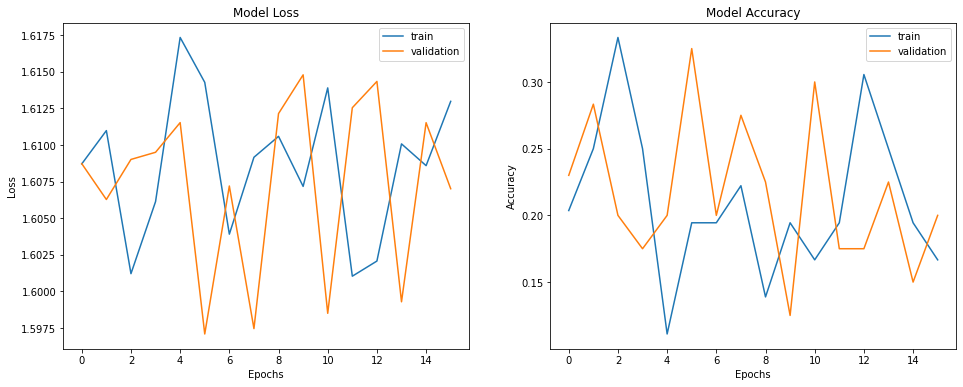

In [10]:
train_gen = AugmentedDataGenerator(mode='train')
val_gen = AugmentedDataGenerator(mode='val')

skip_image_size=2
batch_size= 60
num_epochs =60

train_generator = train_gen.generator(train_path, train_doc, batch_size,skip_image_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size,skip_image_size)

model_generator = ModelGenerator(input_shape=(15,120,120,3))
# Model 2 with 
model = model_generator.model_cv3D2()

train_model(model,batch_size, num_epochs,train_generator,val_generator, _optimizer='sgd')

(30, 120, 120, 3)
# training sequences = 663
# validation sequences = 100
# epochs = 20
Number of epochs 20
Batch Size 10
Current Date time 2021-02-27 15:33:26.009852
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation (Activation)      (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 30, 60, 60, 8)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 30, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_1

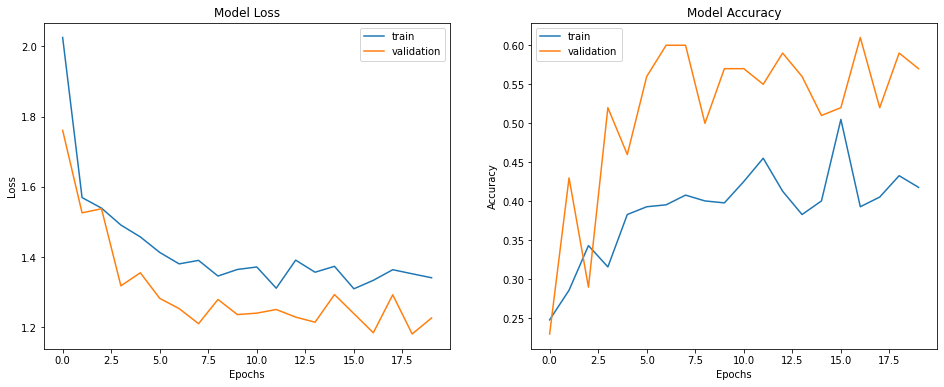

In [21]:
train_gen = AugmentedDataGenerator(mode='train',augment=True,normalize=False)
val_gen = AugmentedDataGenerator(mode='val',normalize=False)

skip_image_size=1
batch_size= 10
num_epochs =20

train_generator = train_gen.generator(train_path, train_doc, batch_size,skip_image_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size,skip_image_size)

model_generator = ModelGenerator(input_shape=(30,120,120,3))
# Model 2 with 
model = model_generator.model_cnn3D_WithBatchNormalization()

train_model(model,batch_size, num_epochs,train_generator,val_generator, _optimizer='sgd')